In [2]:
# Connect to Google Drive 
# Upload the dataset to your Google drive so it can be loaded here

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# First we import the required libraries

import tensorflow as tf
import random
import numpy as np
import pandas as pd
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
import io
import re
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K 
K.clear_session()

# Check tensorflow version
if float(tf.__version__[0]) < 2.0:
  print('Updating tensorflow')
  !pip install tensorflow==2.0
else:
  print('Correct version of Tensorflow installed.')

Correct version of Tensorflow installed.


In [4]:
# import pandas lib as pd
import pandas as pd
 
# read by default 1st sheet of an excel file
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Testing FNH dataset/RandomOverSampler_withFeatures.xlsx', 'Sheet1')
 
print(df)
df = df.fillna(' ')
df.count()

                                                   Title    Len  \
0      White house asks congress for funding on afgha...   3192   
1      Fear of ebola as congolese caught crossing us-...   1315   
2      Sunday screening: better brain health: we are ...   1095   
3                                Trump's weird fed tweet  14123   
4      States pushing back january enrollment deadlin...    233   
...                                                  ...    ...   
14860  Worrying new coronavirus variants aren't just ...  10096   
14861  Lawmakers respond to industry outcry with flex...   1085   
14862  Senate dems to try to stop doj's funding for o...   1914   
14863  Tn primary heats up: name calling and attack a...   2798   
14864  Many considering getting a shingle shot opting...    118   

                                                 Content  \
0      President joe biden's aides on tuesday asked c...   
1      A public health official in laredo, texas, sai...   
2      It appea

Title      14865
Len        14865
Content    14865
Source     14865
Smog       14865
TTR        14865
Label      14865
dtype: int64

In [5]:
# Normalize the dataset
def normalize(data):
    normalized = []
    for i in data:
        i = i.lower()
        # get rid of urls
        i = re.sub('https?://\S+|www\.\S+', '', i)
        # get rid of non words and extra spaces
        i = re.sub('\\W', ' ', i)
        i = re.sub('\n', '', i)
        i = re.sub(' +', ' ', i)
        i = re.sub('^ ', '', i)
        i = re.sub(' $', '', i)
        normalized.append(i)
    return normalized

df['Content'] = normalize(df['Content'])

In [6]:
# Tokenize text

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Content'])
word_index = tokenizer.word_index
vocab_size=len(word_index)
print(vocab_size)

# Padding data

sequences = tokenizer.texts_to_sequences(df['Content'])
padded = pad_sequences(sequences, maxlen=500, padding='post', truncating='post')

90999


**Split 70:30** 

In [7]:
# Spliting data
split = 0.3
split_n = int(round(len(padded)*(1-split),0))

train_data = padded[:split_n]
train_labels = df['Label'].values[:split_n]
test_data = padded[split_n:]
test_labels = df['Label'].values[split_n:]

print("Train label","/n",train_labels)
print("/nTest label","/n",test_labels)

print(type(train_data))
print(len(train_data))
print(type(train_labels))
print(len(train_labels))

Train label /n [0 1 1 ... 0 1 1]
/nTest label /n [0 1 1 ... 0 1 1]
<class 'numpy.ndarray'>
10406
<class 'numpy.ndarray'>
10406


In [8]:
# Import tensor representations for words - GloVe Embedding
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt
embeddings_index = {};
with open('/content/drive/MyDrive/Colab Notebooks/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;
print(len(coefs))

embeddings_matrix = np.zeros((vocab_size+1, 100));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

--2023-02-21 09:17:32--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 108.177.98.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2023-02-21 09:17:32 ERROR 404: Not Found.

100


In [9]:
# Build the architecture of the RNN model
     
model_BiLSTM_7030 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, 100, weights=[embeddings_matrix], trainable=False),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='softmax'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    #tf.keras.layers.Dropout(0.2),  
    tf.keras.layers.Dense(512),
    tf.keras.layers.Dropout(0.3),  
    tf.keras.layers.Dense(256),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [10]:
model_BiLSTM_7030.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_BiLSTM_7030.summary()

history_BiLSTM_7030 = model_BiLSTM_7030.fit(train_data, train_labels, epochs=44, batch_size=200, validation_data=[test_data, test_labels])

print("Training Complete")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         9100000   
                                                                 
 conv1d (Conv1D)             (None, None, 64)          32064     
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 64)         0         
 )                                                               
                                                                 
 bidirectional (Bidirectiona  (None, None, 40)         13600     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                        

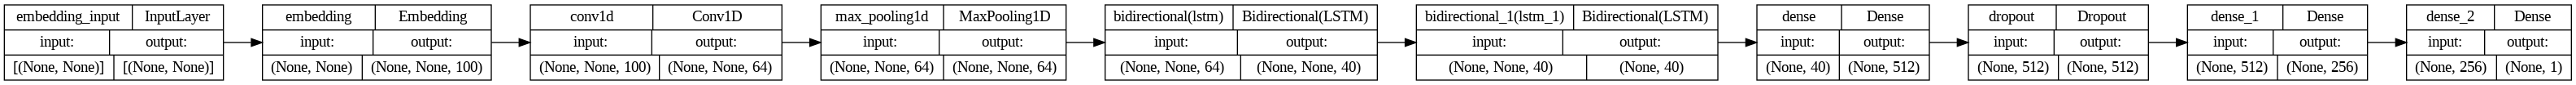

In [11]:
tf.keras.utils.plot_model(model_BiLSTM_7030, show_shapes=True, rankdir="LR")

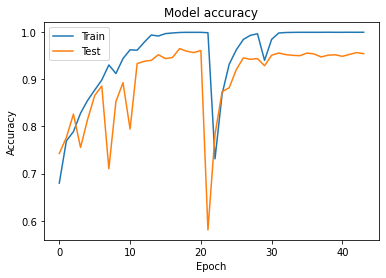

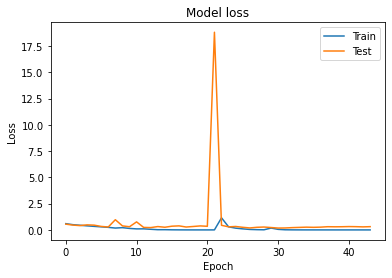

In [12]:
# Visualize the results:

plt.plot(history_BiLSTM_7030.history['accuracy'])
plt.plot(history_BiLSTM_7030.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history_BiLSTM_7030.history['loss'])
plt.plot(history_BiLSTM_7030.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [13]:
pred_BiLSTM_7030 = model_BiLSTM_7030.predict(test_data)

binary_predictions_BiLSTM_7030 = []

for i in pred_BiLSTM_7030:
    if i >= 0.5:
        binary_predictions_BiLSTM_7030.append(1)
    else:
        binary_predictions_BiLSTM_7030.append(0) 

140/140 [==============================] - 3s 9ms/step


[Text(0, 0.5, 'True News'), Text(0, 1.5, 'Fake News')]

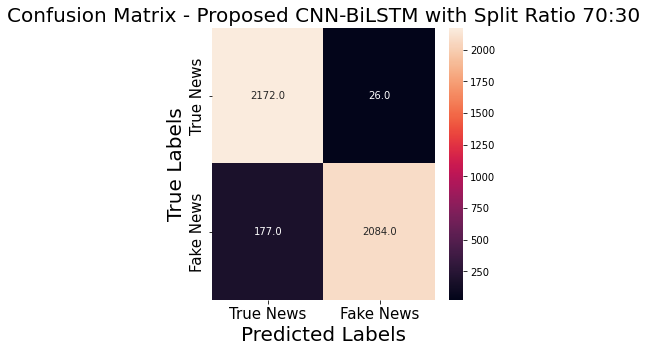

In [14]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(binary_predictions_BiLSTM_7030, test_labels)
plt.figure(figsize=(5, 5))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax, fmt = ".1f")

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix - Proposed CNN-BiLSTM with Split Ratio 70:30', size=20) 
ax.xaxis.set_ticklabels(['True News','Fake News'], size=15)
ax.yaxis.set_ticklabels(['True News','Fake News'], size=15)

In [15]:
# Precision, recall, accuracy score and F1 score

from sklearn import metrics
Accuracy_7030 = metrics.accuracy_score(test_labels, binary_predictions_BiLSTM_7030)
Precision_7030 = metrics.precision_score(test_labels, binary_predictions_BiLSTM_7030)
Sensitivity_recall_7030 = metrics.recall_score(test_labels, binary_predictions_BiLSTM_7030)
Specificity_7030 = metrics.recall_score(test_labels, binary_predictions_BiLSTM_7030, pos_label=0)
F1_score_7030 = metrics.f1_score(test_labels, binary_predictions_BiLSTM_7030)

print("Accuracy of 70:30 BiLSTM Model =", Accuracy_7030)
print("Precision of 70:30 BiLSTM Model =", Precision_7030)
print("Sensitivity_recall of 70:30 BiLSTM Model =", Sensitivity_recall_7030)
print("Specificity of BiLSTM Model 70:30 =", Specificity_7030)
print("F1_score of BiLSTM Model 70:30 =", F1_score_7030)


Accuracy of 70:30 BiLSTM Model = 0.9544740973312402
Precision of 70:30 BiLSTM Model = 0.9217160548429898
Sensitivity_recall of 70:30 BiLSTM Model = 0.9876777251184834
Specificity of BiLSTM Model 70:30 = 0.9246487867177522
F1_score of BiLSTM Model 70:30 = 0.9535575383207503


**Split 90:10** 

In [42]:
# Spliting data
split = 0.1
split_n = int(round(len(padded)*(1-split),0))

train_data = padded[:split_n]
train_labels = df['Label'].values[:split_n]
test_data = padded[split_n:]
test_labels = df['Label'].values[split_n:]

print("Train label","/n",train_labels)
print("/nTest label","/n",test_labels)

print(type(train_data))
print(len(train_data))
print(type(train_labels))
print(len(train_labels))

Train label /n [0 1 1 ... 1 1 1]
/nTest label /n [1 1 0 ... 0 1 1]
<class 'numpy.ndarray'>
13378
<class 'numpy.ndarray'>
13378


In [43]:
# Import tensor representations for words - GloVe Embedding
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt
embeddings_index = {};
with open('/content/drive/MyDrive/Colab Notebooks/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;
print(len(coefs))

embeddings_matrix = np.zeros((vocab_size+1, 100));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

--2023-02-21 09:45:27--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2023-02-21 09:45:27 ERROR 404: Not Found.

100


In [44]:
# Build the architecture of the RNN model
     
model_BiLSTM_9010 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, 100, weights=[embeddings_matrix], trainable=False),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='softmax'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    #tf.keras.layers.Dropout(0.2),  
    tf.keras.layers.Dense(512),
    tf.keras.layers.Dropout(0.3),  
    tf.keras.layers.Dense(256),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [45]:
model_BiLSTM_9010.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_BiLSTM_9010.summary()

history_BiLSTM_9010 = model_BiLSTM_9010.fit(train_data, train_labels, epochs=44, batch_size=200, validation_data=[test_data, test_labels])

print("Training Complete")

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 100)         9100000   
                                                                 
 conv1d_4 (Conv1D)           (None, None, 64)          32064     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, None, 64)         0         
 1D)                                                             
                                                                 
 bidirectional_8 (Bidirectio  (None, None, 40)         13600     
 nal)                                                            
                                                                 
 bidirectional_9 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                      

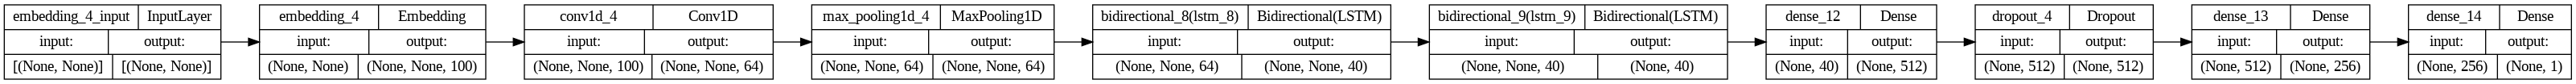

In [46]:
tf.keras.utils.plot_model(model_BiLSTM_9010, show_shapes=True, rankdir="LR")

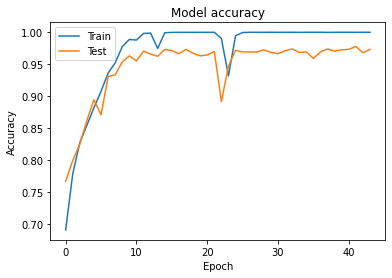

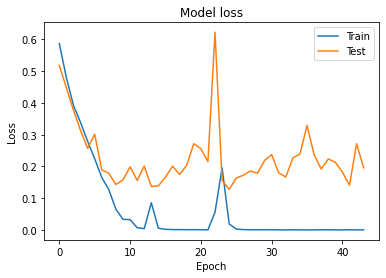

In [47]:
# Visualize the results:

plt.plot(history_BiLSTM_9010.history['accuracy'])
plt.plot(history_BiLSTM_9010.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history_BiLSTM_9010.history['loss'])
plt.plot(history_BiLSTM_9010.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [48]:
pred_9010 = model_BiLSTM_9010.predict(test_data)

binary_predictions_9010 = []

for i in pred_9010:
    if i >= 0.5:
        binary_predictions_9010.append(1)
    else:
        binary_predictions_9010.append(0) 

47/47 [==============================] - 2s 10ms/step


[Text(0, 0.5, 'True News'), Text(0, 1.5, 'Fake News')]

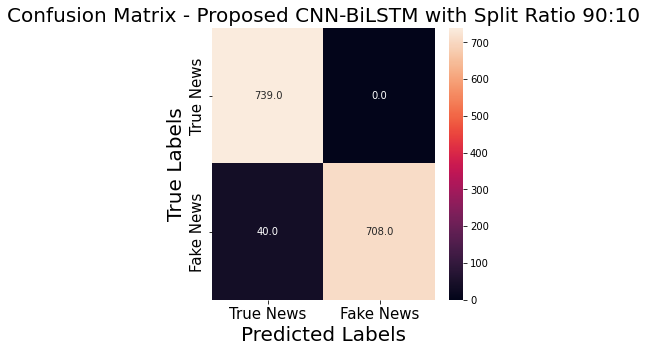

In [49]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(binary_predictions_9010, test_labels)
plt.figure(figsize=(5, 5))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax, fmt = ".1f")

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix - Proposed CNN-BiLSTM with Split Ratio 90:10', size=20) 
ax.xaxis.set_ticklabels(['True News','Fake News'], size=15)
ax.yaxis.set_ticklabels(['True News','Fake News'], size=15)

In [50]:
# Precision, recall, accuracy score and F1 score

from sklearn import metrics
Accuracy_9010 = metrics.accuracy_score(test_labels, binary_predictions_9010)
Precision_9010 = metrics.precision_score(test_labels, binary_predictions_9010)
Sensitivity_recall_9010 = metrics.recall_score(test_labels, binary_predictions_9010)
Specificity_9010 = metrics.recall_score(test_labels, binary_predictions_9010, pos_label=0)
F1_score_9010 = metrics.f1_score(test_labels, binary_predictions_9010)

print("Accuracy of 90:10 BiLSTM Model =", Accuracy_9010)
print("Precision of 90:10 BiLSTM Model =", Precision_9010)
print("Sensitivity_recall of 90:10 BiLSTM Model =", Sensitivity_recall_9010)
print("Specificity of BiLSTM Model 90:10 =", Specificity_9010)
print("F1_score of BiLSTM Model 90:10 =", F1_score_9010)

Accuracy of 90:10 BiLSTM Model = 0.9731002017484869
Precision of 90:10 BiLSTM Model = 0.946524064171123
Sensitivity_recall of 90:10 BiLSTM Model = 1.0
Specificity of BiLSTM Model 90:10 = 0.9486521181001284
F1_score of BiLSTM Model 90:10 = 0.9725274725274725


**Split Ratio 80:20**

In [25]:
# Spliting data
split = 0.2
split_n = int(round(len(padded)*(1-split),0))

train_data = padded[:split_n]
train_labels = df['Label'].values[:split_n]
test_data = padded[split_n:]
test_labels = df['Label'].values[split_n:]

print("Train label","/n",train_labels)
print("/nTest label","/n",test_labels)

print(type(train_data))
print(len(train_data))
print(type(train_labels))
print(len(train_labels))

Train label /n [0 1 1 ... 1 1 0]
/nTest label /n [1 0 0 ... 0 1 1]
<class 'numpy.ndarray'>
11892
<class 'numpy.ndarray'>
11892


In [26]:
# Import tensor representations for words - GloVe Embedding
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt
embeddings_index = {};
with open('/content/drive/MyDrive/Colab Notebooks/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;
print(len(coefs))

embeddings_matrix = np.zeros((vocab_size+1, 100));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

--2023-02-21 09:23:05--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2023-02-21 09:23:05 ERROR 404: Not Found.

100


In [27]:
# Build the architecture of the RNN model
     
model_BiLSTM_8020 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, 100, weights=[embeddings_matrix], trainable=False),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='softmax'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    #tf.keras.layers.Dropout(0.2),  
    tf.keras.layers.Dense(512),
    tf.keras.layers.Dropout(0.3),  
    tf.keras.layers.Dense(256),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [28]:
model_BiLSTM_8020.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_BiLSTM_8020.summary()

history_BiLSTM_8020 = model_BiLSTM_8020.fit(train_data, train_labels, epochs=44, batch_size=200, validation_data=[test_data, test_labels])

print("Training Complete")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 100)         9100000   
                                                                 
 conv1d_2 (Conv1D)           (None, None, 64)          32064     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, None, 64)         0         
 1D)                                                             
                                                                 
 bidirectional_4 (Bidirectio  (None, None, 40)         13600     
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                      

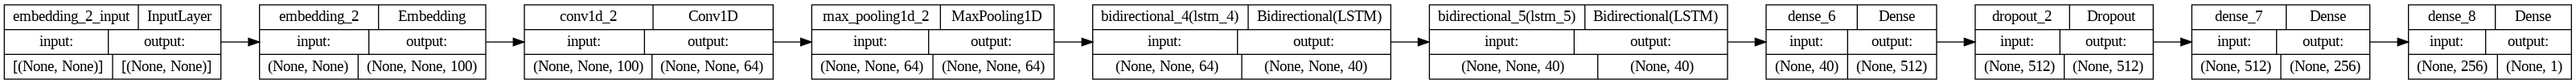

In [29]:
tf.keras.utils.plot_model(model_BiLSTM_8020, show_shapes=True, rankdir="LR")

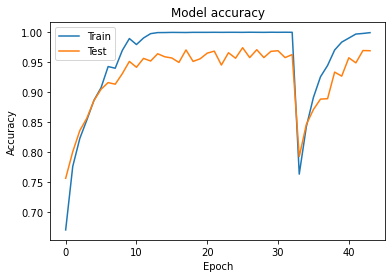

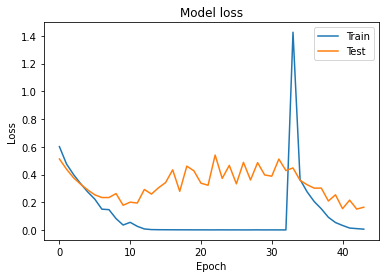

In [30]:
# Visualize the results:

plt.plot(history_BiLSTM_8020.history['accuracy'])
plt.plot(history_BiLSTM_8020.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history_BiLSTM_8020.history['loss'])
plt.plot(history_BiLSTM_8020.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [31]:
pred_8020 = model_BiLSTM_8020.predict(test_data)

binary_predictions_8020 = []

for i in pred_8020:
    if i >= 0.5:
        binary_predictions_8020.append(1)
    else:
        binary_predictions_8020.append(0) 

93/93 [==============================] - 2s 9ms/step


[Text(0, 0.5, 'True News'), Text(0, 1.5, 'Fake News')]

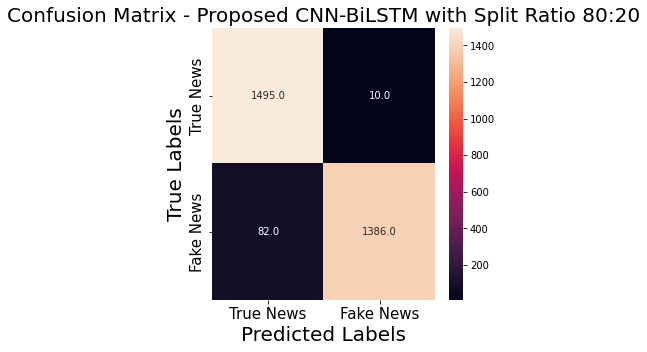

In [32]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(binary_predictions_8020, test_labels)
plt.figure(figsize=(5, 5))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax, fmt = ".1f")

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix - Proposed CNN-BiLSTM with Split Ratio 80:20', size=20) 
ax.xaxis.set_ticklabels(['True News','Fake News'], size=15)
ax.yaxis.set_ticklabels(['True News','Fake News'], size=15)

In [33]:
# Precision, recall, accuracy score and F1 score

from sklearn import metrics
Accuracy_8020 = metrics.accuracy_score(test_labels, binary_predictions_8020)
Precision_8020 = metrics.precision_score(test_labels, binary_predictions_8020)
Sensitivity_recall_8020 = metrics.recall_score(test_labels, binary_predictions_8020)
Specificity_8020 = metrics.recall_score(test_labels, binary_predictions_8020, pos_label=0)
F1_score_8020 = metrics.f1_score(test_labels, binary_predictions_8020)

print("Accuracy of 80:20 BiLSTM Model =", Accuracy_8020)
print("Precision of 80:20 BiLSTM Model =", Precision_8020)
print("Sensitivity_recall of 80:20 BiLSTM Model =", Sensitivity_recall_8020)
print("Specificity of BiLSTM Model 80:20 =", Specificity_8020)
print("F1_score of BiLSTM Model 80:20 =", F1_score_8020)

Accuracy of 80:20 BiLSTM Model = 0.9690548267743021
Precision of 80:20 BiLSTM Model = 0.944141689373297
Sensitivity_recall of 80:20 BiLSTM Model = 0.9928366762177651
Specificity of BiLSTM Model 80:20 = 0.948002536461636
F1_score of BiLSTM Model 80:20 = 0.967877094972067


# **Comparision of Models**

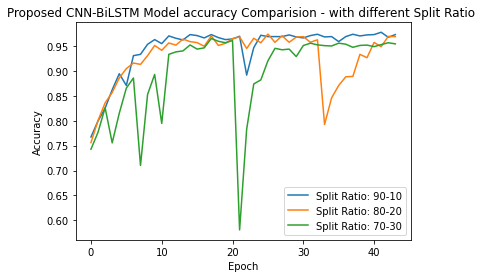

In [54]:
# Accuracy comparision

plt.plot(history_BiLSTM_9010.history['val_accuracy'])
plt.plot(history_BiLSTM_8020.history['val_accuracy'])
plt.plot(history_BiLSTM_7030.history['val_accuracy'])

plt.title('Proposed CNN-BiLSTM Model accuracy Comparision - with different Split Ratio ')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Split Ratio: 90-10', 'Split Ratio: 80-20', 'Split Ratio: 70-30'], loc='lower right')
plt.show()


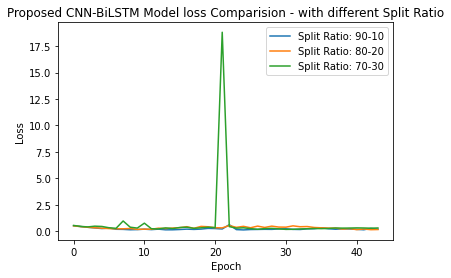

In [53]:
# Loss Comparision
plt.plot(history_BiLSTM_9010.history['val_loss'])
plt.plot(history_BiLSTM_8020.history['val_loss'])
plt.plot(history_BiLSTM_7030.history['val_loss'])

plt.title('Proposed CNN-BiLSTM Model loss Comparision - with different Split Ratio')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Split Ratio: 90-10', 'Split Ratio: 80-20', 'Split Ratio: 70-30'], loc='upper right')
plt.show()